# Going from Products to Projects

One of the goals of product network analysis is to identify nontrivial collections of co-purchased or co-recommended products. We can treat such collections as “customer projects” or “toolsets.” You can find these networks of products frequently purchased together or recommended to be used together in marketing, advertising, and similar business disciplines.

As an example of product network analysis, let’s have a look at cosmetics sold by Sephora®. In this case study, you will learn how to convert a CSV data file with cosmetics co-purchasing data into a complex network with the help of **csv**, **itertools**, and **collections** libraries. You will calculate attribute assortativity of the complex network and blockmodel it — construct its higher level representation as an induced graph. Finally, you will use  produce a picture of the network.

Excerpt From: Dmitry Zinoviev. “Complex Network Analysis in Python.” iBooks. 

## Read Data

Most products on Sephora’s website have _**“Use With”**_ recommendations: one or more other products that the Sephora staff recommends customers purchase in conjunction with the original product. For each product, the website contains plenty of characterizing information, such as brand, category, price, volume, and star rating. Each product is uniquely identified by the store SKU number and an alphanumeric ID. We will build a network of “use-with” products created from previously acquired data and explore its structure concerning the product categories.

For your convenience, we provide the raw data for the network construction in two CSV files. File **use-with.csv** has 3,943 rows; the first row is the header; the remaining rows contain network edges as edge ID (not needed in this case study), start product node, and end product node. We assume that the network is undirected (in reality it is not). File **product.csv** has 2,976 rows; the first row is the header; the remaining rows describe product nodes (one node per row) and contain product attributes as product ID, brand, star rating, and category. The latter two attributes may be empty.


In [1]:
import csv
from collections import Counter
from operator import itemgetter
from itertools import chain, groupby
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import community
import matplotlib.pyplot as plt
import dzcnapy_plotlib as dzcnapy

In [2]:
with open("Products/use-with.csv") as usewith_file:
    reader = csv.reader(usewith_file)
    next(reader)
    G = nx.from_edgelist((n1, n2) for _, n1, n2 in reader)

with open("Products/products.csv") as product_file:
    reader = csv.reader(product_file)
    next(reader)

    brands = {}
    cats = {}
    star_ratings = {}

    for ppid, brand, star_rating, category in reader:
        brands[ppid] = brand
        cats[ppid] = category
        star_ratings[ppid] = float(star_rating if star_rating else 0)

# Set node attributes, based on product attributes
attributes = {"brand" : brands, "category" : cats, "star" : star_ratings}
for att_name, att_value in attributes.items():
    nx.set_node_attributes(G, att_value, att_name)


Note how we use **next(reader)** to skip the header rows in the first two highlighted lines, and how we impute zero star rating for the rows that do not have the star rating field in the last highlighted line.

## Analyze the Networks

The resulting graph G has 2,975 nodes and 3,162 edges. It is very sparse:

In [3]:
print(nx.density(G))

0.0007147660678259198


It also has a lot of small connected components with two to four nodes

In [10]:
ccs=nx.connected_components(G)
print(len(list(ccs)))

609


In [15]:
for cc in sorted(nx.connected_components(G), key = len, reverse=True):
    print(len(cc))

586
75
69
36
34
33
27
25
25
22
21
21
17
17
17
16
14
14
14
13
13
13
12
12
11
11
11
10
10
9
9
9
9
9
9
9
9
9
8
8
8
8
8
8
8
8
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


We consider only the largest component (the GCC). We sort all components of **G** by size, select the last one (the largest!), join the respective label lists into one with **chain.from_iterable**, and extract the subgraph induced by these nodes. We store the resulting subgraph in the variable called **gccs**:

In [16]:
TOP_HOWMANY = 1
gccs_nodes = chain.from_iterable(sorted(nx.connected_components(G),
                                        key=len)[-TOP_HOWMANY:])
gccs = nx.subgraph(G, gccs_nodes)

So, what can we say about the distribution of the graph attributes? Do neighbors tend to be assortative (i.e., they show homophily) or disassortative (e.g., heterophily)? 
(NOTE: degree assortativeness is better analyzed by means of knn(k), see notebook **07_measuring** - do it on your own)

In [20]:
for att_name in attributes:
    print("Assortativity by {}: {}"\
              .format(att_name,
                      nx.attribute_assortativity_coefficient(gccs, att_name)))

Assortativity by brand: 0.8687551723142832
Assortativity by category: 0.035779049762065675
Assortativity by star: -0.005801231122082764


On the one hand, connected products are very likely sold under the same brand—because cosmetic brands provide comprehensive toolkits! On the other hand, connected products belong to different categories—indeed, why would one buy two tools from the same category together? On the third hand (yes, computer scientists can have as many hands as it takes to describe the problem, as long as all hands, except for the first two, are virtual), connected products have unrelated star ratings. The last result is confusing, and you can leave the question open until you can afford to hire a subject-matter expert.

Because of the poor node assortativity by category, we expect a weird mixture of categories within any structural element—e.g., within modularity-defined communities. Let’s partition the network into communities and see how they are connected and named.

In [21]:
part = community.best_partition(gccs)
print("Modularity: {}".format(community.modularity(part, gccs)))
# Modularity: 0.854691821704231

Modularity: 0.8254169099607678


The following statements create a list of lists of nodes in each community by collecting the nodes with the same partition ID. Function **itertools.groupby** demands that the sequence is already sorted by the same key as would be used for grouping. In our case, the key is the partition ID, the second element of each tuple on the list returned by **parts.items**, thus **itemgetter(1)**. We will need the list later to auto-generate community labels.

In [22]:
groups = groupby(sorted(part.items(), key=itemgetter(1)), itemgetter(1))
community_labels = [list(map(itemgetter(0), group)) for _, group in groups]
subgraphs = [nx.subgraph(gccs, labels) for labels in community_labels]

To perform blockmodeling (see notebook **10_makeFigures**), we will utilize community.induced_graph(partition, graph), the blockmodeling tool from the community library.

In [23]:
induced = community.induced_graph(part, gccs)

# The induced graph usually has many self-loops because of copious connections between the 
# nodes in the original network that belong to the same community. 
# We remove the loops (on the highlighted line) to avoid clutter in the future network printout
induced.remove_edges_from(induced.selfloop_edges())

## Name the Components

The new induced graph nicely reflects the macroscopic structure of the original product network. It has only eighteen nodes and twenty-nine edges. The nodes are nameless so far, and we need to give them names. Having no better source of labels than the product categories, we select the most popular category within each induced node as the node label. We need an auxiliary function to obtain the name of the dominant category in a community. The Sephora website reports category names as colon-separated hierarchical paths. To save space in the future printout, we keep only the last path component.

In [24]:
def top_cat_label(community_subgraph):
    items = [atts["category"] for _, atts
             in community_subgraph.nodes(data=True)]
    top_category = Counter(items).most_common(1)[0]
    top_label_path = top_category[0]
    return top_label_path.split(":")[-1]

Function **collections.Counter(sequence)** is an indispensable tool for counting occurrences of unique items in a **sequence**. It returns a dictionary-style **Counter** object with the method **Counter.most_common(n)** that reports a list of the **n** most popular items as **(label,count)** tuples (we only need the item label).

There may be several communities with the same dominant category in the network. If we blindly relabel them, their respective induced nodes will have the same label, and **networkx** will combine them into one node. To avoid unnecessary node merging, let’s append the community ID to each label. The new labels look somewhat odd, but at least they are unique.

In [25]:
mapping = {comm_id: "{}/{}".format(top_cat_label(subgraph), comm_id)
           for comm_id, subgraph in enumerate(subgraphs)}
induced = nx.relabel_nodes(induced, mapping, copy=True)

At this point, our analysis is complete, but the data sponsor (the person or organization who ordered us the study) would rather see a nice picture than read a thousand barely decipherable labels. It is time to produce a picture. Function **graphviz_layout** attempts to find appropriate positions for the graph nodes, and **nx.draw_networkx** draws the graph. The last function takes tons of parameters: you can customize edge and node colors, sizes, labels, etc. You can save the resulting picture into a file, or display it on the screen, or both.

If you cannot run **graphviz_layout** for any reasons, or you just want a better visualization, save the graph to an external file and visulize it through **Gephi*

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['Liberation Sans Narrow'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


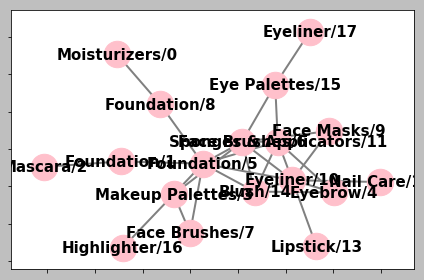

In [26]:
attrs = {"edge_color" : "gray", "font_size" : 12, "font_weight" : "bold",
         "node_size" : 700, "node_color" : "pink", "width" : 2,
         "font_family" : "Liberation Sans Narrow"}

# Calculate best node positions
pos = graphviz_layout(induced)

# Draw the network
nx.draw_networkx(induced, pos, **dzcnapy.attrs)

# Adjust the extents
dzcnapy.set_extent(pos, plt)

# Save and show
dzcnapy.plot("ProductNetwork")

To understand the figure better, let’s explore the degrees of the induced nodes with **nx.degree(induced)**. 

In [27]:
nx.degree(induced)

DegreeView({'Moisturizers/0': 1, 'Foundation/1': 2, 'Mascara/2': 1, 'Makeup Palettes/3': 4, 'Eyebrow/4': 3, 'Foundation/5': 8, 'Face Brushes/6': 7, 'Face Brushes/7': 2, 'Foundation/8': 2, 'Face Masks/9': 2, 'Eyeliner/10': 8, 'Sponges & Applicators/11': 6, 'Nail Care/12': 1, 'Lipstick/13': 1, 'Blush/14': 5, 'Eye Palettes/15': 3, 'Highlighter/16': 1, 'Eyeliner/17': 1})

In [29]:
top_degree = sorted(induced.degree(), reverse=True, key=itemgetter(1))[:100]
print("\n".join(map(lambda t: "{} {}".format(*reversed(t)), top_degree)))

8 Foundation/5
8 Eyeliner/10
7 Face Brushes/6
6 Sponges & Applicators/11
5 Blush/14
4 Makeup Palettes/3
3 Eyebrow/4
3 Eye Palettes/15
2 Foundation/1
2 Face Brushes/7
2 Foundation/8
2 Face Masks/9
1 Moisturizers/0
1 Mascara/2
1 Nail Care/12
1 Lipstick/13
1 Highlighter/16
1 Eyeliner/17


## Discussion

At the top of the list, you can see the cosmetics essentials that are required for makeup but usually go invisible—namely, foundations and tools (brushes, cases, palettes). The most eye-catching tools are at the bottom of the table: mascaras, lipsticks, nail care tools, and highlighters. We can hypothesize that if a node is connected to (recommended to be “used-with”) fewer neighbors, it is more specialized. The specialized nodes are at the periphery of the product network and depend on the more general nodes in the core.

Just like some other case studies presented in the book, the “products to projects” case is not limited only to the Sephora products. Given sufficient co-purchasing data, you can build a network of products, identify dense product communities, name them, and argue about possible reasons for their existence.